# min $D_{hh}$

Max said his student Michael Hank tried out the min $D_{hh}$ pairing, and it really helped the sensitivity for the SUSY analysis, so he asked me to try this out for our SM NR limit as well.

To do this, I needed to modify `resolved-recon` to have a new flag to just minimize $D_{hh}$.

I'm doing this study on EMTopo jets using miniNtuples from the MAY2019 production with just the 2016 dataset.

**Command for running over signal**

`resolved-recon --mc --lumi 24.3 -t triggers-2016.dat -o smnr_min_Dhh.root ../public/hh4b/SMNR/user.saparede.HH4B.450000.SM_HH.MC16a-2015-2016.AB21.2.72-MAY2019_VRFIX.pflow_vr_min-systs-both_MiniNTuple.root/user.saparede.18276059._0000*.MiniNTuple.root --min_Dhh`

**Command for running over background**

`resolved-recon -o data16_min_Dhh.root --unblind -t triggers-2016.dat ../public/hh4b/data/user.bstanisl.HH4B.period?.data16..AB21.2.72-MAY2019.topo_min_MiniNTuple.root/*.root --min_Dhh`

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tqdm import tqdm

os.sys.path.append('../code')
from AnalysisUtils import nanoToDf, getBDTWeights,getExpectedBand, getLambdaWeights
from plotting import sig_bkg_massplanes, bkg_2b_rw_massplanes
from plotting import cf_2b_same_HC, cf_1d_dists
from preprocess import read_tsv

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 1: Look at the massplanes

In [12]:
fileName = "../../hh4b-resolved-reconstruction/{}_min_Dhh.root"
treeName = 'fullmassplane'

smnr   = nanoToDf(fileName.format("smnr"),ttree=treeName)
data16 = nanoToDf(fileName.format("data16"),ttree=treeName)

fullmassplane
fullmassplane


In [13]:
text = "minimize $D_{hh}$"
sig_bkg_massplanes(data16, smnr, text=text,figDir='figures/min_Dhh/')

## Step 2: BDT background estimate

In [15]:
getBDTWeights(data16,BDT_fname,trainBDT=False)

Check the agreement.

In [16]:
makeBDTPlots = True

In [17]:
dataText = "$\mathbf{ATLAS}$ Internal 2016 data\n"
dataText += "min $D_{hh}$"

1326567


../code/plotting.py:751: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


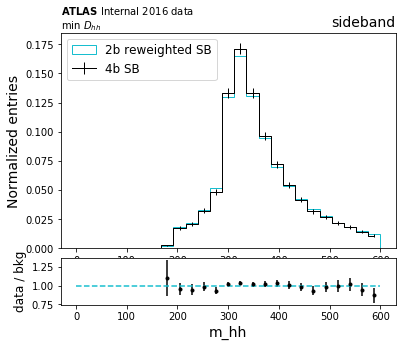

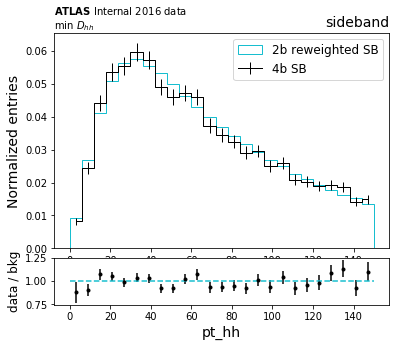

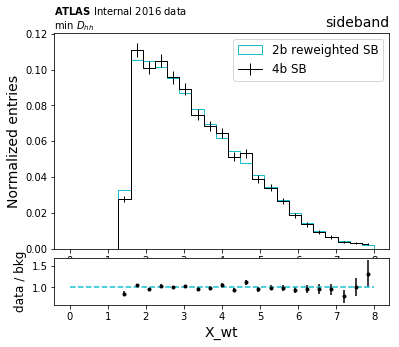

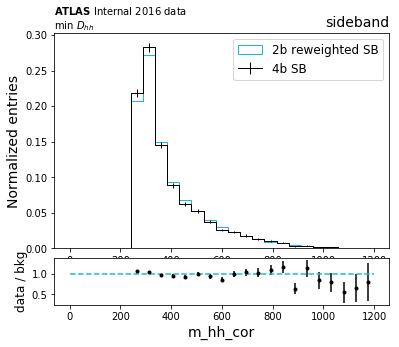

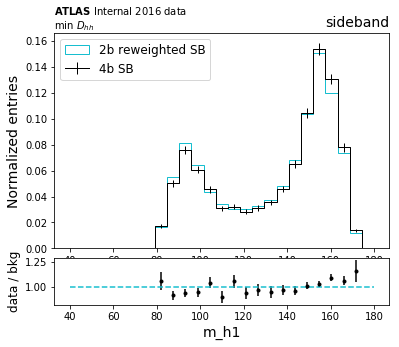

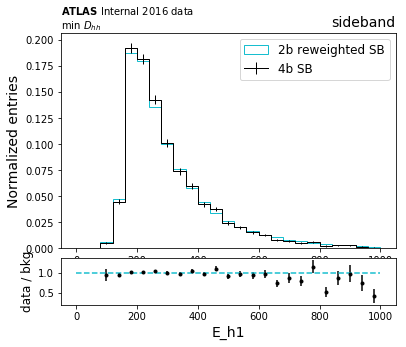

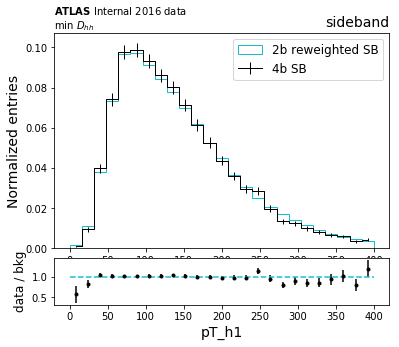

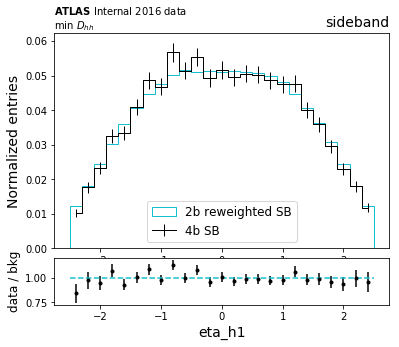

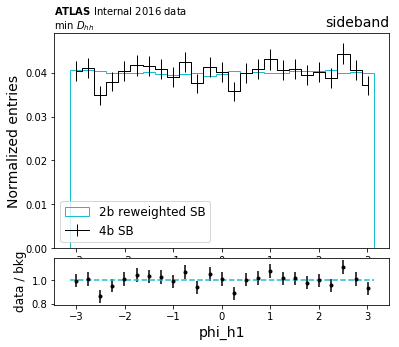

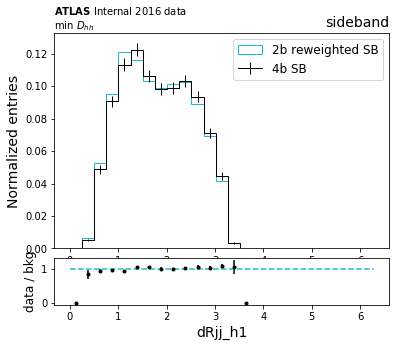

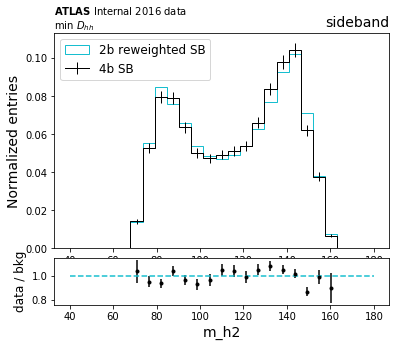

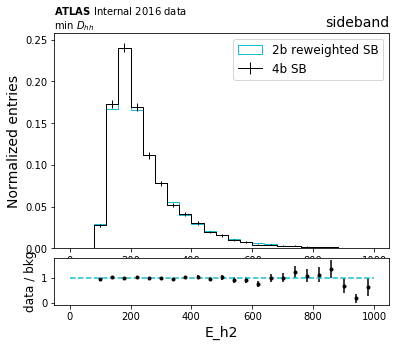

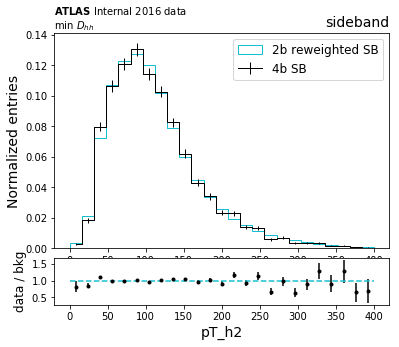

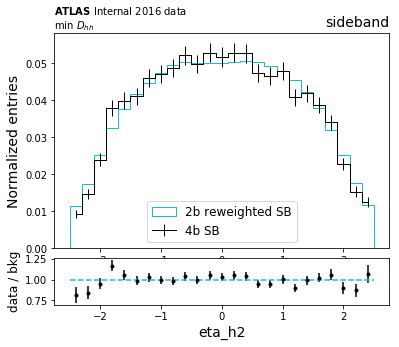

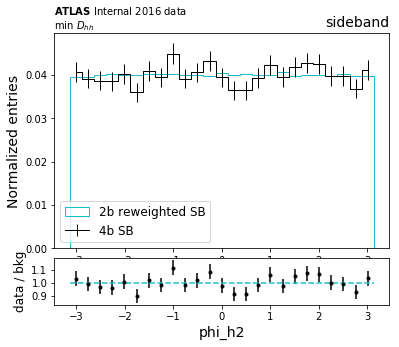

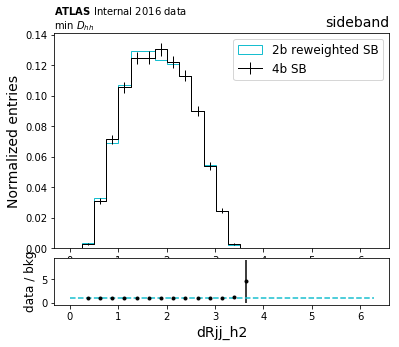

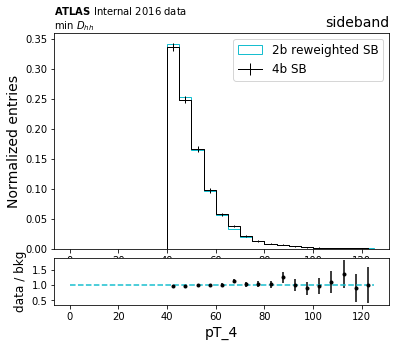

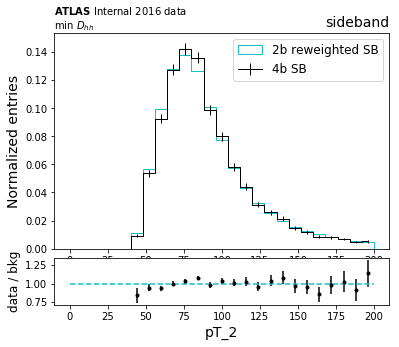

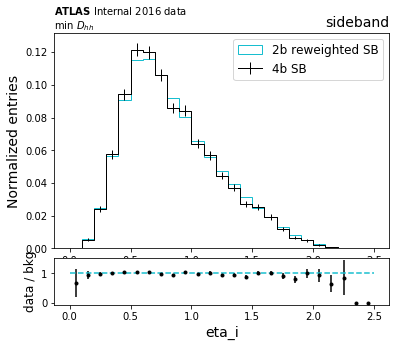

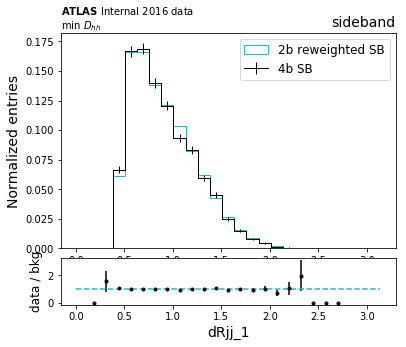

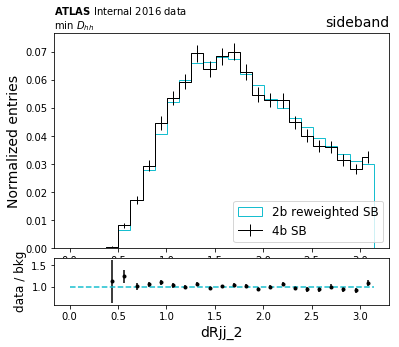

In [18]:
if makeBDTPlots:
    cf_1d_dists(data16,mask=(data16.kinematic_region==2),drawUnweighted=False, 
                dataText=dataText,nbi=25,
                figDir='figures/min_Dhh/rw_2b/',tag='_SB',chi2Only=False)

## Step 3: Signal Histograms

In [70]:
sig_SR = (smnr.kinematic_region==0) & (smnr.ntag>=4)
bkg_SR = (data16.kinematic_region==0) & (data16.ntag==2)

edges = np.array([150, 250, 262, 275, 288, 302, 317, 332, 348, 365, 383, 402, 422, 443, 465, 488, 512, 
                  537, 563, 591, 620, 651, 683, 717, 752, 789, 828, 869, 912, 957,1004, 1054, 1106, 1161, 
                  1219, 1279, 1342, 1409, 1479, 1552, 1629, 1710, 1795, 1884, 1978, 2076])

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


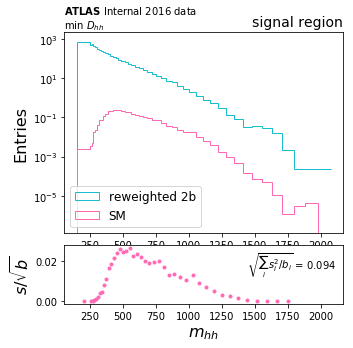

In [91]:
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(4,1)
ax1 = fig.add_subplot(gs[:3,0])
ax2 = fig.add_subplot(gs[3:,0],sharex=ax1)

b,_,_ = ax1.hist(data16.loc[bkg_SR,'m_hh'],
                 edges,color='C9',histtype='step',log=True,
                 label='reweighted 2b',
                 weights=data16.loc[bkg_SR,'w_2b'])

s,_,_ = ax1.hist(smnr.loc[sig_SR,'m_hh'],
                 edges,color='hotpink',histtype='step',log=True,
                 label='SM',
                 weights=smnr.loc[sig_SR,'mc_sf'])

ax2.plot(0.5*(edges[:-1]+edges[1:]),s/np.sqrt(b),marker='.',color='hotpink',linewidth=0)
ax2.set_xlabel('$m_{hh}$',fontsize=16)
#ax2.set_ylim(0,.035)

_,ymax = ax1.get_ylim()
ax1.set_ylim(0,ymax)

ax1.set_ylabel('Entries',fontsize=16)
ax1.text(0,1,dataText,ha='left',va='bottom',transform=ax1.transAxes)

sigText = '$\sqrt{\sum_i{s_i^2 / b_i}}$ = '
sigText += '{:.3f}'.format(np.sqrt(np.sum(s[b!=0]**2 / b[b!=0])))

ax2.text(.975,.9,sigText,ha='right',va='top',transform=ax2.transAxes)
ax2.set_ylabel('$s / \sqrt{b}$',fontsize=16)

ax1.legend(fontsize=12,loc="lower left")

ax1.set_title('signal region', loc='right',fontsize=14)

plt.savefig('figures/min_Dhh/m_hh_SR_log_ratio.pdf',bbox_inches='tight')

plt.show()

Ok, I was a little concerned that the downward fluctuation in one of the background bins might really be driving the significance, but this histogram also has a *huge* decrease in the number of overall background events.

But honestly, this is promising. And, I *think* the fact that we didn't preferentially remove the low $m_{hh}$ tail will make Rafael happy in terms of constraining the background normalization.


In [42]:
fileName

'../../hh4b-resolved-reconstruction/{}_topo_2016triggers.root'

In [73]:
# Data
prev_fileName = "../../hh4b-resolved-reconstruction/{}_topo_2016triggers.root"

prev_smnr   = nanoToDf(prev_fileName.format("smnr"),  ttree=treeName)
prev_data16 = nanoToDf(prev_fileName.format("data16"),ttree=treeName)

# BDT weights
getBDTWeights(prev_data16,"../sensitivityStudy/myBDTs/BDT_d24_16_rel21_baseline.p",trainBDT=False)

# Mask
prev_sig = (prev_smnr.kinematic_region==0) & (prev_smnr.ntag>=4)
prev_bkg = (prev_data16.kinematic_region==0) & (prev_data16.ntag==2)

fullmassplane
fullmassplane


In [74]:
prev_data16.loc[prev_bkg,'w_2b'].sum()

5687.979541838984

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


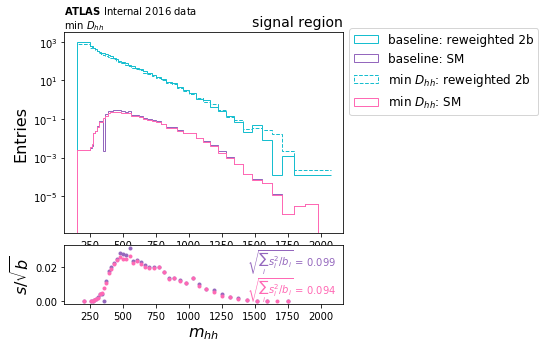

In [120]:
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(4,1)
ax1 = fig.add_subplot(gs[:3,0])
ax2 = fig.add_subplot(gs[3:,0],sharex=ax1)

b0,_,_ = ax1.hist(prev_data16.loc[prev_bkg,'m_hh'],
                  edges,color='C9',histtype='step',log=True,
                  label='baseline: reweighted 2b',
                  weights=prev_data16.loc[prev_bkg,'w_2b'])

s0,_,_ = ax1.hist(prev_smnr.loc[prev_sig,'m_hh'],
                  edges,color='C4',histtype='step',log=True,
                  label='baseline: SM',
                  weights=prev_smnr.loc[prev_sig,'mc_sf'])

b,_,_ = ax1.hist(data16.loc[bkg_SR,'m_hh'],
                 edges,color='C9',histtype='step',log=True,linestyle='--',
                 label='min $D_{hh}$: reweighted 2b',
                 weights=data16.loc[bkg_SR,'w_2b'])

s,_,_ = ax1.hist(smnr.loc[sig_SR,'m_hh'],
                 edges,color='hotpink',histtype='step',log=True,
                 label='min $D_{hh}$: SM',
                 weights=smnr.loc[sig_SR,'mc_sf'])


ax2.plot(0.5*(edges[:-1]+edges[1:]),s0/np.sqrt(b0),marker='.',color='C4',linewidth=0)
ax2.plot(0.5*(edges[:-1]+edges[1:]),s/np.sqrt(b),marker='.',color='hotpink',linewidth=0)
ax2.set_xlabel('$m_{hh}$',fontsize=16)

_,ymax = ax1.get_ylim()
ax1.set_ylim(0,ymax)

ax1.set_ylabel('Entries',fontsize=16)
ax1.text(0,1,dataText,ha='left',va='bottom',transform=ax1.transAxes)


sigText = '$\sqrt{\sum_i{s_i^2 / b_i}}$ = '

ax2.text(.975,.95,
         sigText+'{:.3f}'.format(np.sqrt(np.sum(s0[b0!=0]**2 / b0[b0!=0]))),
         ha='right',va='top',transform=ax2.transAxes,color='C4')
ax2.text(.975,.475,
         sigText+'{:.3f}'.format(np.sqrt(np.sum(s[b!=0]**2 / b[b!=0]))),
         ha='right',va='top',transform=ax2.transAxes,color='hotpink')

ax2.set_ylabel('$s / \sqrt{b}$',fontsize=16)

ax1.legend(fontsize=12,bbox_to_anchor=(1,1.05))

ax1.set_title('signal region', loc='right',fontsize=14)

plt.savefig('figures/min_Dhh/m_hh_SR_log_ratio_cf_baseline.pdf',bbox_inches='tight')

plt.show()

Compare the total number of signal, background, $s/\sqrt{b}$ and $s/b$

In [109]:
cols = ['baseline','min $D_{hh}$']

df = pd.DataFrame(0,index=['$s$','$b$','$s/\sqrt{b}$', '$s/b$'],columns=cols)

for c,sdf,bdf in zip(cols,[prev_smnr[prev_sig],smnr[sig_SR]],[prev_data16[prev_bkg],data16[bkg_SR]]):

    stot,btot = sdf['mc_sf'].sum(), bdf['w_2b'].sum()

    df.loc['$s$',c] = stot
    df.loc['$b$',c] = btot
    df.loc['$s/\sqrt{b}$',c] = stot / np.sqrt(btot)
    df.loc['$s/b$',c] = stot / btot

df['% difference'] = 100 * (df['min $D_{hh}$']-df['baseline']) / df['baseline']
    
df

baseline  min $D_{hh}$  % difference
$s$              3.580334      3.213807    -10.237243
$b$           5687.979542   4895.918180    -13.925180
$s/\sqrt{b}$     0.047473      0.045931     -3.248408
$s/b$            0.000629      0.000656      4.284570

## Step 4: Get the SM NR limit

In [78]:
mu_tests = np.linspace(1,40, 40)
minDhh_band = getExpectedBand(s,b,mu_tests)

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: divide by zero encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: invalid value encountered in multiply
  return n * np.log(lam) - lam - gammaln(n + 1.0)


In [79]:
minDhh_band

[11.433684481212572,
 15.40076951478726,
 21.511830090812357,
 30.20197761640084,
 40.0]

Looks *good*... let's c.f. to the prev analysis in a single plot!

In [80]:
baseline_band = getExpectedBand(s0,b0,mu_tests)

In [81]:
db_entry = read_tsv()
xsec = db_entry.loc[450000,"xsec"]

In [54]:
stdText = '$\mathbf{ATLAS}$ Internal 2016 data\n'
stdText += r'$\sigma_{ggF}(pp \rightarrow HH)$ = '
stdText += "{:.2f} fb\n".format(xsec)
stdText += 'Stats only limit'

-88.04216018277212
-99.7700688424391


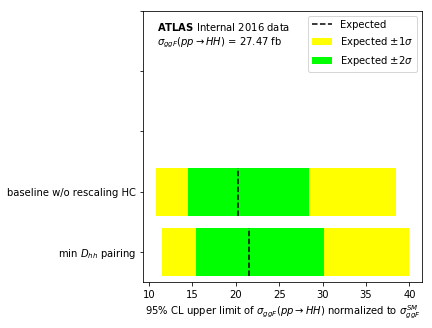

In [116]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

labels = [
    #'baseline 4b analysis',
    'baseline w/o rescaling HC',
    'min $D_{hh}$ pairing'
]

eps = .1

exp_bands = [baseline_band,minDhh_band]

mu_baseline = baseline_band[0]

for i,(ymin, cls_exp) in enumerate(zip(np.arange(len(labels))[::-1],
                                       exp_bands)):
    
    gain = (mu_baseline-cls_exp[2])/mu_baseline*100
    print(gain)
    
    plt.fill_between([cls_exp[0],cls_exp[-1]], [ymin+eps]*2,[ymin+1-eps]*2, 
                     facecolor = 'yellow', 
                     label='Expected $\pm 1\sigma$' if i==0 else None)
    plt.fill_between([cls_exp[1],cls_exp[-2]], [ymin+eps]*2,[ymin+1-eps]*2, 
                     facecolor = 'lime', 
                     label='Expected $\pm 2\sigma$' if i==0 else None)
    
    plt.plot([cls_exp[2]]*2,[ymin+eps,ymin+1-eps],'k--',
             label='Expected' if i==0 else None)
       
ax.set_yticks(np.arange(5)+0.5)
ax.set_yticklabels(labels[::-1])   
 
'''
Put some text on the top of the figure corresponding 
to the signal that we're looking at.
'''
plt.ylim(0,)
plt.text(0.05,0.95,stdText,ha='left',va='top',transform=ax.transAxes)
plt.legend(loc='upper right')
    
plt.xlabel(r'95% CL upper limit of $\sigma_{ggF}(pp \rightarrow HH)$ normalized to $\sigma_{ggF}^{SM}$')

plt.savefig('figures/min_Dhh/exp_mu_cf_validPairs.pdf',bbox_inches='tight')

plt.show()

## Step 5: $\kappa_\lambda$ scan

Not sure if Max wants to see the $\kappa_\lambda$ scan limit as well?

In [84]:
getLambdaWeights(smnr)
getLambdaWeights(prev_smnr)

In [113]:
lambdas = np.arange(-20,21)
normFactor = np.array([np.sum(smnr.loc[sig_SR,'w_lambda{}'.format(l)]) for l in lambdas])

# In pb, since this is what the ATLAS plot has
n = 0.001 * xsec * normFactor


Ok, for this study the background contribution stays the same, and we're just changing the signal histograms.

In [106]:
mu_max = 80
mu_tests_lmbda = np.concatenate((np.linspace(.01,.95,25),np.linspace(1,mu_max,mu_max)))

In [111]:
bands_min_Dhh  = {i:[] for i in range(-2,3)}
bands = {i:[] for i in range(-2,3)}

for l in tqdm(lambdas):
        
    s,_ = np.histogram(smnr.loc[sig_SR,'m_hh'],edges, weights=smnr.loc[sig_SR,'w_lambda{}'.format(l)])
    
    s0,_ = np.histogram(smnr.loc[sig_SR,'m_hh'],edges, weights=smnr.loc[sig_SR,'w_lambda{}'.format(l)])
        
        
    for i, bi in zip(range(-2,3), getExpectedBand(np.where(s>0,s,0), b, mu_tests_lmbda)):
        bands_min_Dhh[i].append(bi)
        
    for i, bi in zip(range(-2,3), getExpectedBand(np.where(s0>0,s0,0), b0, mu_tests_lmbda)):
        bands[i].append(bi)

  0%|          | 0/41 [00:00<?, ?it/s]/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: divide by zero encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: invalid value encountered in multiply
  return n * np.log(lam) - lam - gammaln(n + 1.0)
100%|██████████| 41/41 [02:13<00:00,  3.10s/it]


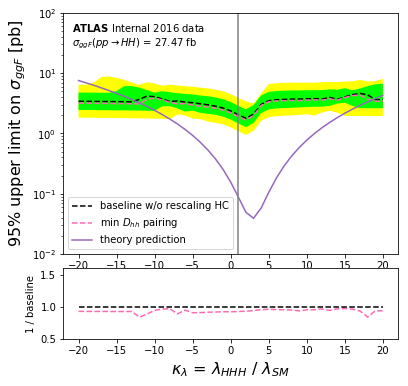

In [118]:
fig = plt.figure(figsize=(6, 6))

gs = gridspec.GridSpec(4,1)
ax = fig.add_subplot(gs[:3,0])
ax2 = fig.add_subplot(gs[3:,0],sharex=ax)

ax.semilogy(lambdas, n * np.array(bands[0]),'k--',label='baseline w/o rescaling HC')

ax.fill_between(lambdas, n * np.array(bands[-2]), n * np.array(bands[2]),  facecolor = 'yellow')
ax.fill_between(lambdas, n * np.array(bands[-1]), n * np.array(bands[1]),  facecolor = 'lime')

# The extra bands that I wanted to add
ax.semilogy(lambdas, n * np.array(bands_min_Dhh[0]),color='hotpink',linestyle='--',label='min $D_{hh}$ pairing')

ax.plot(lambdas,n,'C4',label='theory prediction')

ylim = [.01,100]
ax.plot([1]*2,ylim,'grey')
ax.set_ylim(ylim)

ax.set_ylabel('95% upper limit on $\sigma_{ggF}$ [pb]', fontsize=16)
ax.legend(loc='lower left')

ax2.plot(lambdas,np.array(bands_min_Dhh[0])/np.array(bands[0]),color='hotpink',linestyle='--')

ax2.plot(lambdas,np.ones_like(lambdas),'k--')

ax2.set_xlabel('$\kappa_\lambda$ = $\lambda_{HHH}$ / $\lambda_{SM}$', fontsize=16)
ax2.set_ylabel('1 / baseline')
ax2.set_ylim(0.5,1.6)

ax.text(0.025,.95,stdText,ha='left',va='top',transform=ax.transAxes)

plt.savefig('figures/min_Dhh/kappa_lambda_scan_cf_baseline_ratio.pdf')

plt.show()

Ok, so *possibly* we could do better by reoptimizing the further cuts, but I think this is saying that this isn't a promising direction.